In [2]:
import os
import torch
from tqdm import tqdm
from utils import Classification_Model, Standard_DataLoader, Trainer, load_rgb_mean_std

In [3]:
CWD = os.getcwd()
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE_NAME = torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'CPU'

print(f"CWD: {CWD}")
print(f"DEVICE: {DEVICE_NAME}")

CWD: /mnt/e/xAI-WriterIdentification/HI-EXP/classifier_NN
DEVICE: NVIDIA GeForce RTX 3060


In [4]:
MODEL_PATH = CWD + "/cp/Test_3_TL_val_best_model.pth"
TEST_ID = "CVL-0001-Replicas"
DATASET_DIR = CWD + f"/tests/{TEST_ID}"
OUTPUT_DIR = CWD + f"/tests/{TEST_ID}/output"
SOURCE_DATA_DIR = CWD + "/../../datasets/CVL_Pages"

if not os.path.exists(DATASET_DIR):
    os.mkdir(DATASET_DIR)
    os.mkdir(DATASET_DIR + "/train")
    os.mkdir(DATASET_DIR + "/val")
    os.mkdir(DATASET_DIR + "/test")

if not os.path.exists(OUTPUT_DIR):
    os.mkdir(OUTPUT_DIR)

In [5]:
writer_ids = ['0322', '0018', '0012', '0602', '0556', '0016', '0041']

# Phase 1.1 -> Dataset Splitting

In [6]:
pages = os.listdir(SOURCE_DATA_DIR)
for i in tqdm(range(0, len(pages)), desc="Splitting Dataset"):
    p = pages[i]
    writer_id = p.split("-")[0]
    page_id = int(p.split("-")[1])

    if writer_id in writer_ids:

        if not os.path.exists(DATASET_DIR + f"/train/{writer_id}"):
            os.mkdir(DATASET_DIR + f"/train/{writer_id}")
        if not os.path.exists(DATASET_DIR + f"/val/{writer_id}"):
            os.mkdir(DATASET_DIR + f"/val/{writer_id}")
        if not os.path.exists(DATASET_DIR + f"/test/{writer_id}"):
            os.mkdir(DATASET_DIR + f"/test/{writer_id}")
    
        if page_id in [1,3,4]:          # Train Pages
            os.system(f"cp " + SOURCE_DATA_DIR + f"/{p} " + DATASET_DIR + f"/train/{writer_id}/{p}")
        elif page_id == 2:              # Validation Pages
            os.system(f"cp " + SOURCE_DATA_DIR + f"/{p} " + DATASET_DIR + f"/val/{writer_id}/{p}")
        elif page_id == 6:              # Test Pages
            os.system(f"cp " + SOURCE_DATA_DIR + f"/{p} " + DATASET_DIR + f"/test/{writer_id}/{p}")
        else:
            continue

Splitting Dataset: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1604/1604 [00:01<00:00, 968.53it/s]


# Phase 1.2 -> Dataset Enhancing

In [7]:
folders = ['/train', '/val', '/test']

for f in folders:
    for w in writer_ids:
        for img in os.listdir(f"{DATASET_DIR}/{f}/{w}"):
            for i in range(0, 18):
                os.system(f"cp {DATASET_DIR}/{f}/{w}/{img} {DATASET_DIR}/{f}/{w}/{img[:-4]}_cp{i}.png")

# Phase 2 -> System Fine-Tuning

In [8]:
num_classes = len(os.listdir(DATASET_DIR + "/test"))
model = Classification_Model(num_classes=num_classes, mode='frozen', cp_path=MODEL_PATH)
model = model.to(DEVICE)

pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Number of classes: {num_classes}")
print(f'Number of trainable parameters: {pytorch_total_params}')

Number of classes: 7
Number of trainable parameters: 33095


In [9]:
mean_, std_ = load_rgb_mean_std(f"{DATASET_DIR}/train")
train_ds = Standard_DataLoader(directory=f"{DATASET_DIR}/train", batch_size=32, weighted_sampling=True, phase='train', mean=mean_, std=std_, shuffle=True)
val_ds = Standard_DataLoader(directory=f"{DATASET_DIR}/val", batch_size=32, weighted_sampling=False, phase='val', mean=mean_, std=std_, shuffle=False)
tds, t_dl = train_ds.load_data()
vds, v_dl = val_ds.load_data()

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 399/399 [01:07<00:00,  5.94it/s]


In [10]:
os.mkdir(f"{OUTPUT_DIR}/checkpoints")
torch.backends.cudnn.benchmark = True
trainer = Trainer(model=model, t_set=t_dl, v_set=v_dl, DEVICE=DEVICE, optim_type='adamw', lr_=0.02, 
                  model_path=OUTPUT_DIR, history_path=OUTPUT_DIR, test_ID=TEST_ID, num_epochs=100)
trainer()

Epoch 1 / 100


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:30<00:00,  2.33s/it]


train_loss: 2.010471247192612 - train_accuracy: 0.18045112781954886



Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:06<00:00,  1.26s/it]


val_loss: 3.1603695996721886 - val_accuracy: 0.17293233082706766

Epoch 2 / 100


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:28<00:00,  2.19s/it]


train_loss: 1.9572689664692509 - train_accuracy: 0.18045112781954886



Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:05<00:00,  1.20s/it]


val_loss: 1.8807198839976376 - val_accuracy: 0.21052631578947367

Epoch 3 / 100


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:28<00:00,  2.22s/it]


train_loss: 1.8793084062729264 - train_accuracy: 0.2882205513784461



Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:06<00:00,  1.23s/it]


val_loss: 2.3764045399830755 - val_accuracy: 0.15037593984962405

Epoch 4 / 100


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:28<00:00,  2.17s/it]


train_loss: 1.7908358493245633 - train_accuracy: 0.2957393483709273



Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:05<00:00,  1.19s/it]


val_loss: 4.712605329384481 - val_accuracy: 0.14285714285714285

Epoch 5 / 100


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:27<00:00,  2.15s/it]


train_loss: 1.80938000039648 - train_accuracy: 0.2907268170426065



Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:06<00:00,  1.22s/it]


val_loss: 2.0614351249278937 - val_accuracy: 0.12030075187969924

Epoch 6 / 100


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:28<00:00,  2.16s/it]


train_loss: 1.8415931316844203 - train_accuracy: 0.2631578947368421



Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:06<00:00,  1.22s/it]


val_loss: 2.5806484813977004 - val_accuracy: 0.14285714285714285

Epoch 7 / 100


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:28<00:00,  2.18s/it]


train_loss: 1.6707688339969569 - train_accuracy: 0.37092731829573933



Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:05<00:00,  1.19s/it]


val_loss: 2.6373123011194672 - val_accuracy: 0.24060150375939848

Epoch 8 / 100


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:28<00:00,  2.23s/it]


train_loss: 1.731074279412291 - train_accuracy: 0.2982456140350877



Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:06<00:00,  1.21s/it]


val_loss: 2.4792084084417585 - val_accuracy: 0.14285714285714285

Epoch 9 / 100


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:28<00:00,  2.21s/it]


train_loss: 1.6279489492115222 - train_accuracy: 0.3558897243107769



Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:06<00:00,  1.24s/it]


val_loss: 2.335464963339325 - val_accuracy: 0.24812030075187969

Epoch 10 / 100


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:29<00:00,  2.25s/it]


train_loss: 1.5488238812688 - train_accuracy: 0.40852130325814534



Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:06<00:00,  1.25s/it]


val_loss: 2.528372241142101 - val_accuracy: 0.3684210526315789

Epoch 11 / 100


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:28<00:00,  2.22s/it]


train_loss: 1.5686159522312326 - train_accuracy: 0.38345864661654133



Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:06<00:00,  1.22s/it]


val_loss: 1.601602367888716 - val_accuracy: 0.42105263157894735

Epoch 12 / 100


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:29<00:00,  2.27s/it]


train_loss: 1.5973527733245887 - train_accuracy: 0.39849624060150374



Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:06<00:00,  1.27s/it]


val_loss: 3.538232498599174 - val_accuracy: 0.3458646616541353

Epoch 13 / 100


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:28<00:00,  2.16s/it]


train_loss: 1.6462573810926355 - train_accuracy: 0.3383458646616541



Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:05<00:00,  1.17s/it]


val_loss: 1.7737509809938588 - val_accuracy: 0.2631578947368421

Epoch 14 / 100


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:28<00:00,  2.16s/it]


train_loss: 1.621256867446995 - train_accuracy: 0.37844611528822053



Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:06<00:00,  1.20s/it]


val_loss: 2.183723911755067 - val_accuracy: 0.3609022556390977

Epoch 15 / 100


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:28<00:00,  2.22s/it]


train_loss: 1.6028740367196257 - train_accuracy: 0.39097744360902253



Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:05<00:00,  1.14s/it]


val_loss: 3.2707890316956023 - val_accuracy: 0.21052631578947367

Epoch 16 / 100


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:27<00:00,  2.14s/it]


train_loss: 1.5713345000618382 - train_accuracy: 0.38847117794486213



Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:06<00:00,  1.21s/it]


val_loss: 2.559539110140693 - val_accuracy: 0.3082706766917293

Epoch 17 / 100


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:28<00:00,  2.18s/it]


train_loss: 1.5277410195883654 - train_accuracy: 0.41353383458646614



Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:06<00:00,  1.26s/it]


val_loss: 2.162008299863428 - val_accuracy: 0.21052631578947367

Epoch 18 / 100


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:28<00:00,  2.20s/it]


train_loss: 1.5919461731325115 - train_accuracy: 0.37844611528822053



Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:06<00:00,  1.20s/it]


val_loss: 1.4271324456186223 - val_accuracy: 0.41353383458646614

Epoch 19 / 100


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:28<00:00,  2.16s/it]


train_loss: 1.5735382678215963 - train_accuracy: 0.40601503759398494



Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:06<00:00,  1.24s/it]


val_loss: 1.650863748744018 - val_accuracy: 0.3233082706766917

Epoch 20 / 100


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:27<00:00,  2.15s/it]


train_loss: 1.5094492157599084 - train_accuracy: 0.38345864661654133



Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:05<00:00,  1.13s/it]


val_loss: 1.3431028297969274 - val_accuracy: 0.5112781954887218

Epoch 21 / 100


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:28<00:00,  2.20s/it]


train_loss: 1.4423246775055887 - train_accuracy: 0.42606516290726815



Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:06<00:00,  1.21s/it]


val_loss: 1.5810506092874628 - val_accuracy: 0.39097744360902253

Epoch 22 / 100


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:28<00:00,  2.17s/it]


train_loss: 1.4253263494424653 - train_accuracy: 0.47869674185463656



Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:06<00:00,  1.21s/it]


val_loss: 2.6222335270472934 - val_accuracy: 0.22556390977443608

Epoch 23 / 100


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:28<00:00,  2.19s/it]


train_loss: 1.5449876528335993 - train_accuracy: 0.39598997493734334



Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:06<00:00,  1.20s/it]


val_loss: 1.975586846358794 - val_accuracy: 0.3458646616541353

Epoch 24 / 100


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:27<00:00,  2.15s/it]


train_loss: 1.5009306023891706 - train_accuracy: 0.39849624060150374



Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:05<00:00,  1.16s/it]


val_loss: 2.1208627309117998 - val_accuracy: 0.3007518796992481

Epoch 25 / 100


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:27<00:00,  2.12s/it]


train_loss: 1.4610045517895156 - train_accuracy: 0.43107769423558895



Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:06<00:00,  1.22s/it]


val_loss: 2.6571340041053024 - val_accuracy: 0.20300751879699247

Epoch 26 / 100


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:28<00:00,  2.18s/it]


train_loss: 1.4988867886980672 - train_accuracy: 0.42105263157894735



Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:05<00:00,  1.19s/it]


val_loss: 2.5773099078271624 - val_accuracy: 0.3007518796992481

Epoch 27 / 100


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:28<00:00,  2.20s/it]


train_loss: 1.5375722461475765 - train_accuracy: 0.39849624060150374



Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:06<00:00,  1.20s/it]


val_loss: 1.8481213239798868 - val_accuracy: 0.2781954887218045

Epoch 28 / 100


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:27<00:00,  2.13s/it]


train_loss: 1.4566281624605184 - train_accuracy: 0.43609022556390975



Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:06<00:00,  1.21s/it]


val_loss: 4.864375325970184 - val_accuracy: 0.2781954887218045

Epoch 29 / 100


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:28<00:00,  2.22s/it]


train_loss: 1.4611685810830062 - train_accuracy: 0.42857142857142855



Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:06<00:00,  1.21s/it]


val_loss: 2.0488681309205248 - val_accuracy: 0.21804511278195488

Epoch 30 / 100


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:28<00:00,  2.20s/it]


train_loss: 1.4137701528114186 - train_accuracy: 0.40852130325814534



Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:06<00:00,  1.23s/it]


val_loss: 1.579295735610159 - val_accuracy: 0.47368421052631576

Epoch 31 / 100


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:27<00:00,  2.15s/it]


train_loss: 1.4289339320701466 - train_accuracy: 0.44611528822055135



Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:06<00:00,  1.21s/it]


val_loss: 2.193306661189947 - val_accuracy: 0.3308270676691729

Epoch 32 / 100


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:28<00:00,  2.20s/it]


train_loss: 1.475640370433492 - train_accuracy: 0.41854636591478694



Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:05<00:00,  1.20s/it]


val_loss: 2.0786135806176897 - val_accuracy: 0.3007518796992481

Epoch 33 / 100


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:28<00:00,  2.22s/it]


train_loss: 1.4407241284697874 - train_accuracy: 0.43609022556390975



Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:06<00:00,  1.22s/it]


val_loss: 1.934091295514788 - val_accuracy: 0.39097744360902253

Epoch 34 / 100


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:29<00:00,  2.26s/it]


train_loss: 1.525703001440617 - train_accuracy: 0.40601503759398494



Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:06<00:00,  1.22s/it]


val_loss: 3.1355108031652925 - val_accuracy: 0.23308270676691728

Epoch 35 / 100


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:29<00:00,  2.23s/it]


train_loss: 1.3477727643828046 - train_accuracy: 0.48370927318295737



Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:06<00:00,  1.21s/it]


val_loss: 1.3949859698015945 - val_accuracy: 0.48872180451127817

Epoch 36 / 100


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:29<00:00,  2.25s/it]


train_loss: 1.503275651979566 - train_accuracy: 0.40601503759398494



Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:05<00:00,  1.20s/it]


val_loss: 1.9360038705338212 - val_accuracy: 0.44360902255639095

Epoch 37 / 100


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:28<00:00,  2.22s/it]


train_loss: 1.423544238683275 - train_accuracy: 0.46365914786967416



Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:06<00:00,  1.22s/it]


val_loss: 2.2981654324925933 - val_accuracy: 0.2932330827067669

Epoch 38 / 100


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:28<00:00,  2.17s/it]


train_loss: 1.5333122298831032 - train_accuracy: 0.39348370927318294



Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:06<00:00,  1.21s/it]


val_loss: 2.273783739348103 - val_accuracy: 0.3157894736842105

Epoch 39 / 100


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:28<00:00,  2.19s/it]


train_loss: 1.4450050714918246 - train_accuracy: 0.45363408521303256



Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:06<00:00,  1.21s/it]


val_loss: 2.6277498087488618 - val_accuracy: 0.2932330827067669

Epoch 40 / 100


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:28<00:00,  2.22s/it]


train_loss: 1.4866224261453576 - train_accuracy: 0.42606516290726815



Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:06<00:00,  1.23s/it]


val_loss: 4.005021866102864 - val_accuracy: 0.14285714285714285

Epoch 41 / 100


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:30<00:00,  2.31s/it]


train_loss: 1.4195115109135334 - train_accuracy: 0.45864661654135336



Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:05<00:00,  1.20s/it]


val_loss: 2.2809461166984155 - val_accuracy: 0.3684210526315789

Epoch 42 / 100


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:28<00:00,  2.21s/it]


train_loss: 1.3929142990805452 - train_accuracy: 0.45363408521303256



Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:05<00:00,  1.19s/it]


val_loss: 1.7081749210680337 - val_accuracy: 0.42105263157894735

Epoch 43 / 100


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:28<00:00,  2.16s/it]


train_loss: 1.5203886002227478 - train_accuracy: 0.43107769423558895



Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:06<00:00,  1.21s/it]


val_loss: 4.722718640377647 - val_accuracy: 0.20300751879699247

Epoch 44 / 100


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:28<00:00,  2.16s/it]


train_loss: 1.4744491015460557 - train_accuracy: 0.46365914786967416



Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:05<00:00,  1.16s/it]


val_loss: 1.5128247486917596 - val_accuracy: 0.5714285714285714

Epoch 45 / 100


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:28<00:00,  2.16s/it]


train_loss: 1.4199806096261007 - train_accuracy: 0.45864661654135336



Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:05<00:00,  1.20s/it]


val_loss: 1.3557060679098718 - val_accuracy: 0.46616541353383456

Epoch 46 / 100


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:28<00:00,  2.18s/it]


train_loss: 1.500830564582557 - train_accuracy: 0.41353383458646614



Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:06<00:00,  1.21s/it]


val_loss: 2.901114725528803 - val_accuracy: 0.16541353383458646

Epoch 47 / 100


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:28<00:00,  2.16s/it]


train_loss: 1.3950357646272893 - train_accuracy: 0.44862155388471175



Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:06<00:00,  1.20s/it]


val_loss: 3.87039958265491 - val_accuracy: 0.2631578947368421

Epoch 48 / 100


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:28<00:00,  2.18s/it]


train_loss: 1.4483715767848462 - train_accuracy: 0.41854636591478694



Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:06<00:00,  1.20s/it]


val_loss: 2.0349627795972323 - val_accuracy: 0.42857142857142855

Epoch 49 / 100


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:27<00:00,  2.14s/it]


train_loss: 1.487399359095963 - train_accuracy: 0.44110275689223055



Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:05<00:00,  1.18s/it]


val_loss: 3.086009889617002 - val_accuracy: 0.16541353383458646

Epoch 50 / 100


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:28<00:00,  2.16s/it]


train_loss: 1.4885404829990894 - train_accuracy: 0.43609022556390975



Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:06<00:00,  1.21s/it]


val_loss: 1.6000836307841135 - val_accuracy: 0.3609022556390977

Epoch 51 / 100


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:28<00:00,  2.19s/it]


train_loss: 1.3529713180728424 - train_accuracy: 0.5213032581453634



Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:06<00:00,  1.20s/it]


val_loss: 1.306663988228131 - val_accuracy: 0.42105263157894735

Epoch 52 / 100


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:28<00:00,  2.20s/it]


train_loss: 1.413535181741069 - train_accuracy: 0.45363408521303256



Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:06<00:00,  1.21s/it]


val_loss: 2.0353760916487613 - val_accuracy: 0.42857142857142855

Epoch 53 / 100


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:28<00:00,  2.19s/it]


train_loss: 1.2754266366623996 - train_accuracy: 0.49874686716791977



Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:05<00:00,  1.19s/it]


val_loss: 6.261802189332202 - val_accuracy: 0.14285714285714285

Epoch 54 / 100


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:28<00:00,  2.20s/it]


train_loss: 1.419015141358053 - train_accuracy: 0.48370927318295737



Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:05<00:00,  1.18s/it]


val_loss: 4.281437949130409 - val_accuracy: 0.23308270676691728

Epoch 55 / 100


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:28<00:00,  2.20s/it]


train_loss: 1.4084588934604387 - train_accuracy: 0.45614035087719296



Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:06<00:00,  1.24s/it]


val_loss: 1.6004185013304977 - val_accuracy: 0.3609022556390977

Epoch 56 / 100


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:28<00:00,  2.20s/it]


train_loss: 1.4012801554567533 - train_accuracy: 0.46365914786967416



Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:05<00:00,  1.16s/it]


val_loss: 1.3447169020659941 - val_accuracy: 0.46616541353383456

Epoch 57 / 100


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:27<00:00,  2.13s/it]


train_loss: 1.3839058277003449 - train_accuracy: 0.46616541353383456



Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:06<00:00,  1.24s/it]


val_loss: 2.3382784728717088 - val_accuracy: 0.3684210526315789

Epoch 58 / 100


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:28<00:00,  2.16s/it]


train_loss: 1.3545472798192113 - train_accuracy: 0.47368421052631576



Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:05<00:00,  1.20s/it]


val_loss: 2.310339291292922 - val_accuracy: 0.19548872180451127

Epoch 59 / 100


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:28<00:00,  2.22s/it]


train_loss: 1.3095630592570866 - train_accuracy: 0.5238095238095238



Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:06<00:00,  1.21s/it]


val_loss: 3.142143394714011 - val_accuracy: 0.16541353383458646

Epoch 60 / 100


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:28<00:00,  2.17s/it]


train_loss: 1.461366681825547 - train_accuracy: 0.41854636591478694



Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:06<00:00,  1.20s/it]


val_loss: 2.4969251568156077 - val_accuracy: 0.3383458646616541

Epoch 61 / 100


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:28<00:00,  2.18s/it]


train_loss: 1.3634497234994607 - train_accuracy: 0.45363408521303256



Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:06<00:00,  1.24s/it]


val_loss: 2.457352398033429 - val_accuracy: 0.37593984962406013

Epoch 62 / 100


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:28<00:00,  2.23s/it]


train_loss: 1.375553688011074 - train_accuracy: 0.47619047619047616



Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:06<00:00,  1.23s/it]


val_loss: 2.4360496442120776 - val_accuracy: 0.47368421052631576

Epoch 63 / 100


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:29<00:00,  2.24s/it]


train_loss: 1.446146545553566 - train_accuracy: 0.42857142857142855



Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:06<00:00,  1.23s/it]


val_loss: 3.164444317495016 - val_accuracy: 0.2932330827067669

Epoch 64 / 100


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:27<00:00,  2.15s/it]


train_loss: 1.3610819476588925 - train_accuracy: 0.5012531328320802



Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:05<00:00,  1.19s/it]


val_loss: 2.4845759151573468 - val_accuracy: 0.2857142857142857

Epoch 65 / 100


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:27<00:00,  2.13s/it]


train_loss: 1.3950897520944887 - train_accuracy: 0.48621553884711777



Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:05<00:00,  1.20s/it]


val_loss: 1.8386741894528382 - val_accuracy: 0.5037593984962406

Epoch 66 / 100


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:28<00:00,  2.21s/it]


train_loss: 1.3753447750756018 - train_accuracy: 0.46115288220551376



Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:06<00:00,  1.24s/it]


val_loss: 1.4297928137886793 - val_accuracy: 0.3157894736842105

Epoch 67 / 100


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:29<00:00,  2.25s/it]


train_loss: 1.3838098228425908 - train_accuracy: 0.47368421052631576



Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:06<00:00,  1.22s/it]


val_loss: 1.7873336264961643 - val_accuracy: 0.2932330827067669

Epoch 68 / 100


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:28<00:00,  2.19s/it]


train_loss: 1.3944736569746394 - train_accuracy: 0.45864661654135336



Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:06<00:00,  1.22s/it]


val_loss: 2.424711625378831 - val_accuracy: 0.2556390977443609

Epoch 69 / 100


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:28<00:00,  2.21s/it]


train_loss: 1.3909069918152084 - train_accuracy: 0.47869674185463656



Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:06<00:00,  1.23s/it]


val_loss: 1.690252020843047 - val_accuracy: 0.2932330827067669

Epoch 70 / 100


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:27<00:00,  2.15s/it]


train_loss: 1.408308322268321 - train_accuracy: 0.45614035087719296



Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:06<00:00,  1.25s/it]


val_loss: 2.5732742252206444 - val_accuracy: 0.3684210526315789

Epoch 71 / 100


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:28<00:00,  2.20s/it]


train_loss: 1.3972670087838233 - train_accuracy: 0.44110275689223055



Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:05<00:00,  1.18s/it]


val_loss: 2.447054025822116 - val_accuracy: 0.3157894736842105

Epoch 72 / 100


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:28<00:00,  2.20s/it]


train_loss: 1.4119054990304742 - train_accuracy: 0.46115288220551376



Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:05<00:00,  1.19s/it]


val_loss: 1.6010151465136306 - val_accuracy: 0.3684210526315789

Epoch 73 / 100


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:27<00:00,  2.13s/it]


train_loss: 1.4064635381961526 - train_accuracy: 0.46115288220551376



Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:05<00:00,  1.19s/it]


val_loss: 1.7163682172172947 - val_accuracy: 0.42857142857142855

Epoch 74 / 100


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:27<00:00,  2.11s/it]


train_loss: 1.3197139062379535 - train_accuracy: 0.518796992481203



Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:05<00:00,  1.18s/it]


val_loss: 2.491311756291784 - val_accuracy: 0.3308270676691729

Epoch 75 / 100


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:28<00:00,  2.17s/it]


train_loss: 1.3269679949695903 - train_accuracy: 0.5137844611528822



Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:06<00:00,  1.25s/it]


val_loss: 2.4735290089944253 - val_accuracy: 0.42857142857142855

Epoch 76 / 100


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:28<00:00,  2.17s/it]


train_loss: 1.3869834696141101 - train_accuracy: 0.46365914786967416



Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:06<00:00,  1.23s/it]


val_loss: 2.1786178789640727 - val_accuracy: 0.2706766917293233

Epoch 77 / 100


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:28<00:00,  2.16s/it]


train_loss: 1.469034865386504 - train_accuracy: 0.45363408521303256



Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:06<00:00,  1.24s/it]


val_loss: 1.1405444163128846 - val_accuracy: 0.5789473684210527

Epoch 78 / 100


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:28<00:00,  2.21s/it]


train_loss: 1.3568402770766639 - train_accuracy: 0.45864661654135336



Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:05<00:00,  1.19s/it]


val_loss: 2.9710627570188137 - val_accuracy: 0.2857142857142857

Epoch 79 / 100


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:27<00:00,  2.12s/it]


train_loss: 1.311809521868713 - train_accuracy: 0.5338345864661654



Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:05<00:00,  1.18s/it]


val_loss: 2.0124079374442423 - val_accuracy: 0.41353383458646614

Epoch 80 / 100


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:27<00:00,  2.13s/it]


train_loss: 1.3543703457466643 - train_accuracy: 0.5012531328320802



Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:05<00:00,  1.17s/it]


val_loss: 2.0292611498581734 - val_accuracy: 0.22556390977443608

Epoch 81 / 100


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:28<00:00,  2.19s/it]


train_loss: 1.3139674538060238 - train_accuracy: 0.47869674185463656



Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:06<00:00,  1.26s/it]


val_loss: 3.5304269790649414 - val_accuracy: 0.24060150375939848

Epoch 82 / 100


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:28<00:00,  2.17s/it]


train_loss: 1.3525302460916657 - train_accuracy: 0.48872180451127817



Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:06<00:00,  1.23s/it]


val_loss: 4.737579069639507 - val_accuracy: 0.2631578947368421

Epoch 83 / 100


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:28<00:00,  2.23s/it]


train_loss: 1.3858959116135026 - train_accuracy: 0.48120300751879697



Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:06<00:00,  1.22s/it]


val_loss: 2.3265111159561274 - val_accuracy: 0.3684210526315789

Epoch 84 / 100


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:27<00:00,  2.12s/it]


train_loss: 1.384479900948087 - train_accuracy: 0.44611528822055135



Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:05<00:00,  1.14s/it]


val_loss: 1.4586281866059267 - val_accuracy: 0.38345864661654133

Epoch 85 / 100


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:28<00:00,  2.18s/it]


train_loss: 1.365528663298241 - train_accuracy: 0.46365914786967416



Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:06<00:00,  1.21s/it]


val_loss: 1.4956936863131989 - val_accuracy: 0.3684210526315789

Epoch 86 / 100


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:28<00:00,  2.19s/it]


train_loss: 1.3322153987741112 - train_accuracy: 0.5238095238095238



Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:05<00:00,  1.16s/it]


val_loss: 3.7047780653587856 - val_accuracy: 0.2932330827067669

Epoch 87 / 100


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:27<00:00,  2.15s/it]


train_loss: 1.2305524591216468 - train_accuracy: 0.5639097744360902



Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:05<00:00,  1.16s/it]


val_loss: 2.5305495333850834 - val_accuracy: 0.2857142857142857

Epoch 88 / 100


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:28<00:00,  2.18s/it]


train_loss: 1.311541349367988 - train_accuracy: 0.49373433583959897



Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:06<00:00,  1.22s/it]


val_loss: 4.167911622757302 - val_accuracy: 0.15037593984962405

Epoch 89 / 100


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:28<00:00,  2.18s/it]


train_loss: 1.413354838701119 - train_accuracy: 0.45112781954887216



Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:06<00:00,  1.21s/it]


val_loss: 4.715586375473137 - val_accuracy: 0.21804511278195488

Epoch 90 / 100


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:28<00:00,  2.16s/it]


train_loss: 1.3195080488247979 - train_accuracy: 0.5012531328320802



Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:06<00:00,  1.21s/it]


val_loss: 1.8221996699957024 - val_accuracy: 0.44360902255639095

Epoch 91 / 100


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:28<00:00,  2.20s/it]


train_loss: 1.3542286044075376 - train_accuracy: 0.47869674185463656



Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:05<00:00,  1.20s/it]


val_loss: 2.1439397711502877 - val_accuracy: 0.42105263157894735

Epoch 92 / 100


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:28<00:00,  2.17s/it]


train_loss: 1.343390303148064 - train_accuracy: 0.49624060150375937



Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:05<00:00,  1.20s/it]


val_loss: 4.587526407456936 - val_accuracy: 0.2706766917293233

Epoch 93 / 100


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:28<00:00,  2.21s/it]


train_loss: 1.3327383520011615 - train_accuracy: 0.47117794486215536



Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:06<00:00,  1.20s/it]


val_loss: 1.725557427657278 - val_accuracy: 0.3308270676691729

Epoch 94 / 100


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:28<00:00,  2.19s/it]


train_loss: 1.334697947466284 - train_accuracy: 0.49122807017543857



Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:06<00:00,  1.23s/it]


val_loss: 1.7695709655159397 - val_accuracy: 0.42105263157894735

Epoch 95 / 100


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:28<00:00,  2.20s/it]


train_loss: 1.4173003593483067 - train_accuracy: 0.46867167919799496



Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:06<00:00,  1.23s/it]


val_loss: 1.4214947367073 - val_accuracy: 0.45112781954887216

Epoch 96 / 100


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:28<00:00,  2.22s/it]


train_loss: 1.4191984562646776 - train_accuracy: 0.46115288220551376



Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:06<00:00,  1.21s/it]


val_loss: 2.058578980596442 - val_accuracy: 0.24060150375939848

Epoch 97 / 100


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:28<00:00,  2.20s/it]


train_loss: 1.3899947575160436 - train_accuracy: 0.44360902255639095



Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:06<00:00,  1.21s/it]


val_loss: 2.214975597266864 - val_accuracy: 0.21052631578947367

Epoch 98 / 100


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:28<00:00,  2.22s/it]


train_loss: 1.455468223507243 - train_accuracy: 0.47368421052631576



Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:06<00:00,  1.27s/it]


val_loss: 1.5833839715871596 - val_accuracy: 0.37593984962406013

Epoch 99 / 100


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:28<00:00,  2.20s/it]


train_loss: 1.3508475194300027 - train_accuracy: 0.48872180451127817



Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:06<00:00,  1.24s/it]


val_loss: 1.6869732759948959 - val_accuracy: 0.44360902255639095

Epoch 100 / 100


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:28<00:00,  2.17s/it]


train_loss: 1.340516525701174 - train_accuracy: 0.47869674185463656



Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:06<00:00,  1.22s/it]

val_loss: 1.487455575537861 - val_accuracy: 0.40601503759398494



# Phase 3 -> Print Results for Training

In [11]:
import pickle as pkl
import matplotlib.pyplot as plt
import numpy as np

In [12]:
losses = {'train': [], 'val': []}
accs = {'train': [], 'val': []}

In [13]:
for loss in list(losses.keys()):
    with open(f'{OUTPUT_DIR}/Test_{TEST_ID}_MLC_{loss}_losses.pkl', 'rb') as f:
        losses[loss] = pkl.load(f)

In [14]:
with open(f'{OUTPUT_DIR}/Test_{TEST_ID}_MLC_losses.txt', 'w') as f:
    f.write('The optimal value of loss for the training set is: {:01.3f}\n'.format(np.min(losses['train'])))
    f.write('The optimal value of loss for the validation set is: {:01.3f}\n'.format(np.min(losses['val'])))
    best_epoch_train = np.where(np.array(losses['train']) == min(losses['train']))[0][0] + 1
    best_epoch = np.where(np.array(losses['val']) == min(losses['val']))[0][0] + 1
    f.write(f"Epoch corresponding to the optimal value of the training loss: {best_epoch_train}\\{len(losses['train'])}\n")
    f.write(f"Epoch corresponding to the optimal value of the validation loss: {best_epoch}\\{len(losses['val'])}\n")

In [15]:
plt.plot(losses['train'])
plt.plot(losses['val'])
plt.title('Model loss')
plt.ylabel('Loss [-]')
plt.xlabel('Epoch [-]')
plt.legend(['Training', 'Validation'], loc='best')
plt.savefig(f'{OUTPUT_DIR}/Test_{TEST_ID}_MLC_losses.png')
plt.close()

In [16]:
for acc in list(accs.keys()):
    with open(f'{OUTPUT_DIR}/Test_{TEST_ID}_MLC_{acc}_accuracy.pkl', 'rb') as f:
        accs[acc] = pkl.load(f)

In [17]:
with open(f'{OUTPUT_DIR}/Test_{TEST_ID}_MLC_accuracy.txt', 'w') as f:
    f.write('The optimal value of accuracy for the training set is: {:01.3f}\n'.format(np.max(accs['train'])))
    f.write('The optimal value of accuracy for the validation set is: {:01.3f}\n'.format(np.max(accs['val'])))
    best_epoch_train = np.where(np.array(accs['train']) == max(accs['train']))[0][0] + 1
    best_epoch = np.where(np.array(accs['val']) == max(accs['val']))[0][0] + 1
    f.write(f"Epoch corresponding to the optimal value of the training accuracy: {best_epoch_train}\\{len(accs['train'])}\n")
    f.write(f"Epoch corresponding to the optimal value of the validation accuracy: {best_epoch}\\{len(accs['val'])}\n")

In [18]:
plt.plot(accs['train'])
plt.plot(accs['val'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy [-]')
plt.xlabel('Epoch [-]')
plt.legend(['Training', 'Validation'], loc='best')
plt.savefig(f'{OUTPUT_DIR}/Test_{TEST_ID}_MLC_accuracy.png')
plt.close()  

# Phase 4 -> Testing & Reports

In [19]:
torch.cuda.empty_cache()

In [20]:
from utils import Classification_Model, Standard_DataLoader, load_rgb_mean_std, produce_classification_reports

In [21]:
cp_base = f"./cp/Test_3_TL_val_best_model.pth"
cp = f"{OUTPUT_DIR}/checkpoints/Test_{TEST_ID}_MLC_val_best_model.pth"
num_classes = len(os.listdir(DATASET_DIR + "/test"))

In [22]:
model = Classification_Model(num_classes=num_classes, mode='frozen', cp_path=cp_base)
model = model.to(DEVICE)
model.load_state_dict(torch.load(cp)['model_state_dict'])
model.eval()

Classification_Model(
  (base_model): BaseModel(
    (enc): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d

/home/xodiec/.pyenv/versions/3.10.12/envs/NewVenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/xodiec/.pyenv/versions/3.10.12/envs/NewVenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/xodiec/.pyenv/versions/3.10.12/envs/NewVenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _wa

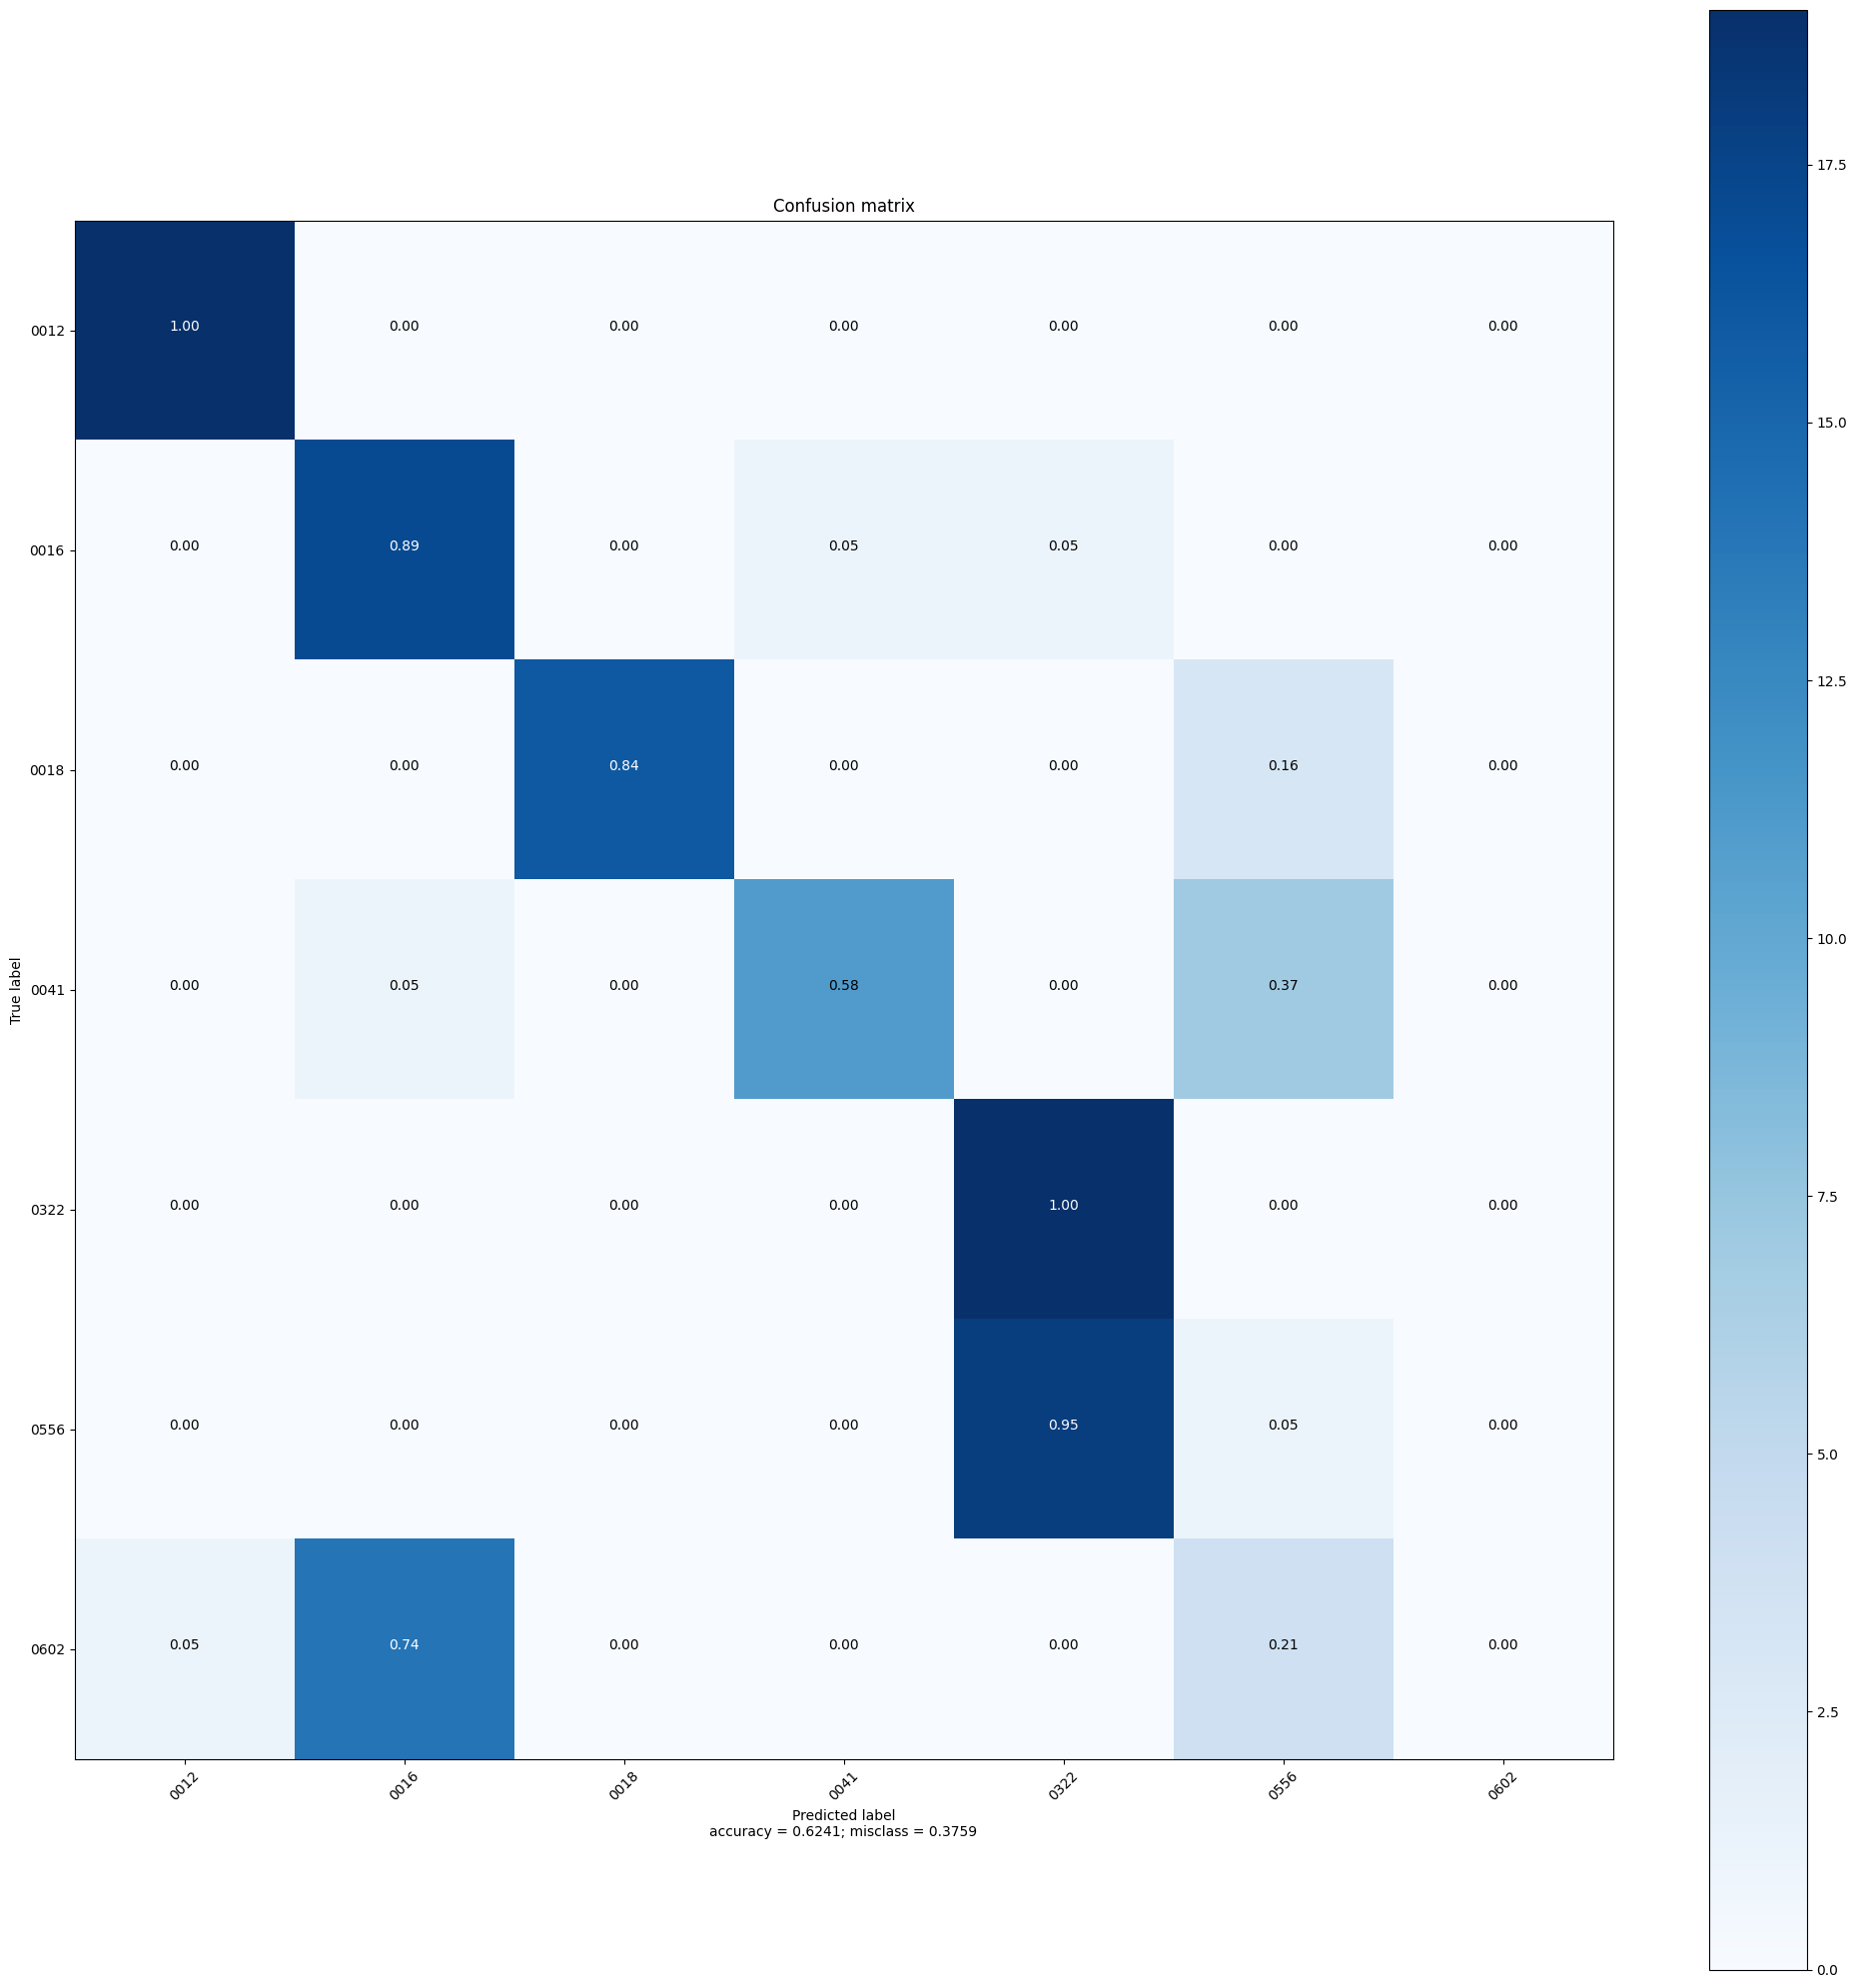

In [23]:
mean_, std_ = load_rgb_mean_std(f"{DATASET_DIR}/train")
dl = Standard_DataLoader(f"{DATASET_DIR}/test", 64, False, 'test', mean_, std_, True)
produce_classification_reports(dl, DEVICE, model, OUTPUT_DIR, TEST_ID)